In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Path to your CSV file
file_path = 'ciciot_2023.csv'

# Read the CSV file, and immediately change float64 columns to float32
df = pd.read_csv(file_path).astype({col: 'float32' for col in pd.read_csv(file_path, nrows=1).select_dtypes(include=['float64']).columns})

# Now df contains the data from the CSV file with float64 columns converted to float32

In [4]:
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() < df.shape[0] * 0.5:  # Threshold for conversion
        df[col] = df[col].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56197 entries, 0 to 56196
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   flow_duration    56197 non-null  float32 
 1   Header_Length    56197 non-null  float32 
 2   Protocol Type    56197 non-null  float32 
 3   Duration         56197 non-null  float32 
 4   Rate             56197 non-null  float32 
 5   Srate            56197 non-null  float32 
 6   fin_flag_number  56197 non-null  float32 
 7   syn_flag_number  56197 non-null  float32 
 8   rst_flag_number  56197 non-null  float32 
 9   psh_flag_number  56197 non-null  float32 
 10  ack_flag_number  56197 non-null  float32 
 11  ack_count        56197 non-null  float32 
 12  syn_count        56197 non-null  float32 
 13  fin_count        56197 non-null  float32 
 14  urg_count        56197 non-null  float32 
 15  rst_count        56197 non-null  float32 
 16  HTTP             56197 non-null  float32

In [6]:
df['label'] = df['label'].map(lambda a: 'Normal' if a == 'BenignTraffic' else 'Attack')

In [7]:
print(df['label'].value_counts())

label
Attack    53989
Normal     2208
Name: count, dtype: int64


In [8]:
# Creating a dictionary of Types
attacks = {'Attack':0, 'Normal':1}
df['label'] = df['label'].map(attacks)

In [9]:
X = df.drop(columns=['label'])
y = df['label']

In [10]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the original training data for simple validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [11]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Extra Trees model

In [30]:
# Initialize the Extra Trees classifier with default parameters
extra_trees = ExtraTreesClassifier()

# Record the start time for training
start_time = time.time()

# Fit the model on the training data
extra_trees.fit(X_train, y_train)

# Calculate and print the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.3f} seconds')

# Record the start time for prediction
start_time = time.time()

# Make predictions on the test data
y_pred = extra_trees.predict(X_test)

# Calculate and print the testing time
testing_time = time.time() - start_time
print(f'Testing Time: {testing_time:.3f} seconds')

Training Time: 0.719 seconds
Testing Time: 0.045 seconds


In [13]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9937
Precision: 0.9459
Recall: 0.9739
F1 Score: 0.9595


In [14]:
# Find the unique labels in your test set
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter your attacks dictionary to only include keys with values present in unique_labels
filtered_attacks = {k: v for k, v in attacks.items() if v in unique_labels}

# Now use the filtered attack names as target_names in your classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=list(filtered_attacks.values()), target_names=list(filtered_attacks.keys())))

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     10798
      Normal       0.89      0.95      0.92       442

    accuracy                           0.99     11240
   macro avg       0.95      0.97      0.96     11240
weighted avg       0.99      0.99      0.99     11240



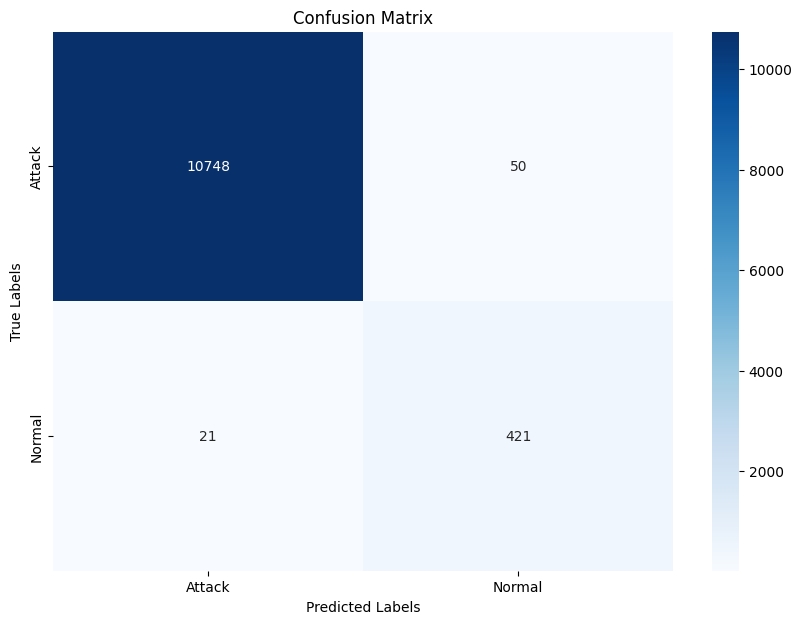

In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attacks.keys(), yticklabels=attacks.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

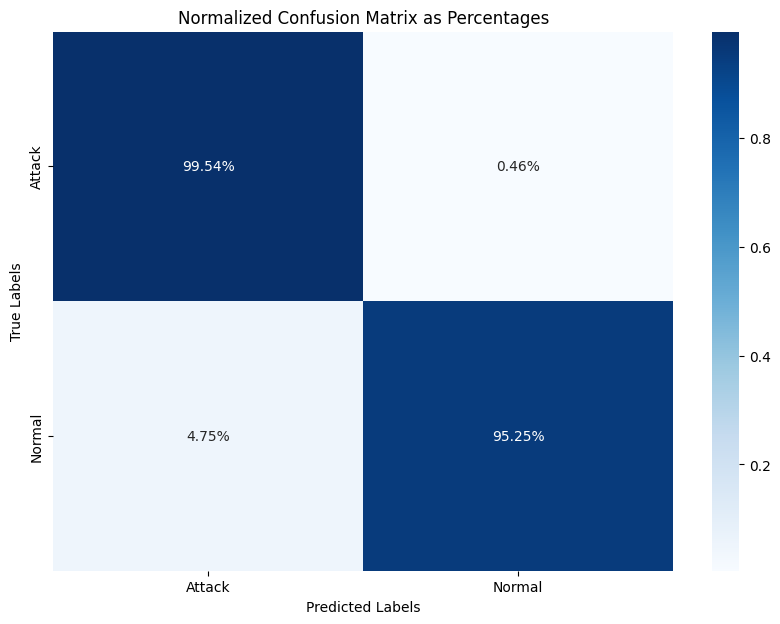

In [16]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()

In [17]:
print(extra_trees)

ExtraTreesClassifier()


# Hyperparameters Optimization

In [18]:
def objective_function(hyperparameters, X_train, y_train, X_val, y_val):
     # Ensure parameter values are within valid ranges
     n_estimators = max(int(hyperparameters[0]), 10)  # Ensuring n_estimators is at least 10
     max_depth = None if hyperparameters[1] < 0 else max(int(hyperparameters[1]), 1)
     min_samples_split = max(int(hyperparameters[2]), 2)
     min_samples_leaf = max(int(hyperparameters[3]), 1)
     max_features = map_max_features(hyperparameters[4])  # Use mapped value
     bootstrap = hyperparameters[5] > 0.5  # Convert to boolean

     model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  max_features=max_features, bootstrap=bootstrap, random_state=42)
    
     model.fit(X_train, y_train)
     y_pred = model.predict(X_val)
     return -accuracy_score(y_val, y_pred)  # Negative accuracy for minimization

# Harmony Search Algorithm

In [19]:
def harmony_search(objective_func, X_train, y_train, X_val, y_val, memory_size=10, n_iter=100, hmcr=0.9, par=0.3, bw=0.01):
     # Initialize Harmony Memory (HM) with valid ranges
     HM = np.random.rand(memory_size, 6)
     # Scale the random values to match expected ranges of hyperparameters
     HM[:, 0] = HM[:, 0] * 190 + 10  # n_estimators from 10 to 200
     HM[:, 1] = HM[:, 1] * 19 + 1  # max_depth from 1 to 20
     HM[:, 2] = HM[:, 2] * 9 + 2  # min_samples_split from 2 to 11
     HM[:, 3] = HM[:, 3] * 9 + 1  # min_samples_leaf from 1 to 10
     HM[:, 4] = HM[:, 4]  # max_features, keep as is, will be mapped later
     HM[:, 5] = HM[:, 5] > 0.5  # bootstrap represented as a boolean

     best_score = float('inf')
     best_harmony = None

     for _ in range(n_iter):
         new_harmony = np.zeros(6)
         for i in range(6):
             if np.random.rand() < hmcr:  # Harmony Memory Consideration Rate
                 new_harmony[i] = HM[np.random.randint(0, memory_size), i]
                 if np.random.rand() < par:  # Pitch Adjustment Rate
                     # Ensure adjustments are within bounds
                     if i == 0:  # n_estimators
                         adjustment = int(bw * 100 * (np.random.rand() - 0.5) * 2)
                     elif i in [1, 2, 3]:  # max_depth, min_samples_split, min_samples_leaf
                         adjustment = int(bw * 10 * (np.random.rand() - 0.5) * 2)
                     elif i == 4:  # max_features as a fraction
                         adjustment = bw * (np.random.rand() - 0.5) * 2
                     else:  # bootstrap, no adjustment needed
                         adjustment = 0
                     new_harmony[i] += adjustment
             else:
                 # Random initialization within bounds for each parameter
                 if i == 0:  # n_estimators
                     new_harmony[i] = np.random.rand() * 190 + 10
                 elif i in [1, 2, 3]:  # max_depth, min_samples_split, min_samples_leaf
                     new_harmony[i] = np.random.rand() * 19 + 1
                 elif i == 4:  # max_features
                     new_harmony[i] = np.random.rand()
                 else:  # bootstrap
                     new_harmony[i] = np.random.rand() > 0.5

         # Correct scaling or bounds application after generation
         new_harmony[0] = max(int(new_harmony[0]), 10)  # n_estimators must be at least 10
         new_harmony[1] = None if new_harmony[1] < 0 else max(int(new_harmony[1]), 1)  # max_depth
         new_harmony[2] = max(int(new_harmony[2]), 2)  # min_samples_split
         new_harmony[3] = max(int(new_harmony[3]), 1)  # min_samples_leaf
         new_harmony[4] = max(min(new_harmony[4], 1), 0)  # max_features as a fraction

         score = objective_func(new_harmony, X_train, y_train, X_val, y_val)

         if score < best_score:
             best_score = score
             best_harmony = new_harmony

         # Update HM with new harmony if better than the worst in HM
         worst_idx = np.argmax([objective_func(HM[i, :], X_train, y_train, X_val, y_val) for i in range(memory_size)])
         worst_score = objective_func(HM[worst_idx, :], X_train, y_train, X_val, y_val)
         if score < worst_score:
             HM[worst_idx, :] = new_harmony

     return best_harmony

In [20]:
def map_max_features(value):
    # Assuming 'value' is a continuous variable from 0 to 1 obtained from harmony search
    if value < 0.25:
        return 'sqrt'  # Changed from 'auto' to 'sqrt' to comply with ExtraTreesClassifier specifications
    elif value < 0.5:
        return 'log2'
    elif value < 0.75:
        # Maps to a fraction of features, e.g., 0.5 for half of the features
        return 0.5
    else:
        # Use all features
        return None

# Optimized Extra Trees

In [21]:
start_time = time.time()
# Optimize hyperparameters
best_hyperparams = harmony_search(objective_function, X_train, y_train, X_test, y_test)

# Train the Extra Trees model with optimized hyperparameters
# Use the optimized hyperparameters to configure the Extra Trees model
optimized_model = ExtraTreesClassifier(
    n_estimators=int(best_hyperparams[0]),
    max_depth=None if best_hyperparams[1] < 0 else int(best_hyperparams[1]),
    min_samples_split=int(best_hyperparams[2]),
    min_samples_leaf=int(best_hyperparams[3]),
    max_features=map_max_features(best_hyperparams[4]),  # Ensure this function maps to valid values
    bootstrap=bool(best_hyperparams[5]),
    random_state=42
)
opt_time = time.time() - start_time

print(f'Optimization Time: {opt_time:.3f} seconds')

Optimization Time: 2559.615 seconds


In [22]:
# Assuming 'best_hyperparams' is obtained from the 'harmony_search' function

print(f"n_estimators: {int(best_hyperparams[0])}")
print(f"max_depth: {None if best_hyperparams[1] < 0 else int(best_hyperparams[1])}")
print(f"min_samples_split: {int(best_hyperparams[2])}")
print(f"min_samples_leaf: {int(best_hyperparams[3])}")
print(f"max_features: {best_hyperparams[4]}")  # Assuming this is the raw value used in 'map_max_features'
print(f"bootstrap: {bool(best_hyperparams[5])}")  # Converts to True if non-zero/True, otherwise False

n_estimators: 195
max_depth: 17
min_samples_split: 3
min_samples_leaf: 3
max_features: 0.8836811419794823
bootstrap: False


In [23]:
# Record the start time for training
start_time = time.time()

optimized_model.fit(X_train, y_train)

# Calculate and print the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.3f} seconds')

# Record the start time for prediction
start_time = time.time()

# Evaluate the optimized model
y_pred = optimized_model.predict(X_test)

# Calculate and print the testing time
testing_time = time.time() - start_time
print(f'Testing Time: {testing_time:.3f} seconds')

Training Time: 2.951 seconds
Testing Time: 0.070 seconds


In [24]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9950
Precision: 0.9572
Recall: 0.9790
F1 Score: 0.9678


In [25]:
# Find the unique labels in your test set
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter your attacks dictionary to only include keys with values present in unique_labels
filtered_attacks = {k: v for k, v in attacks.items() if v in unique_labels}

# Now use the filtered attack names as target_names in your classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=list(filtered_attacks.values()), target_names=list(filtered_attacks.keys())))

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     10798
      Normal       0.92      0.96      0.94       442

    accuracy                           1.00     11240
   macro avg       0.96      0.98      0.97     11240
weighted avg       1.00      1.00      1.00     11240



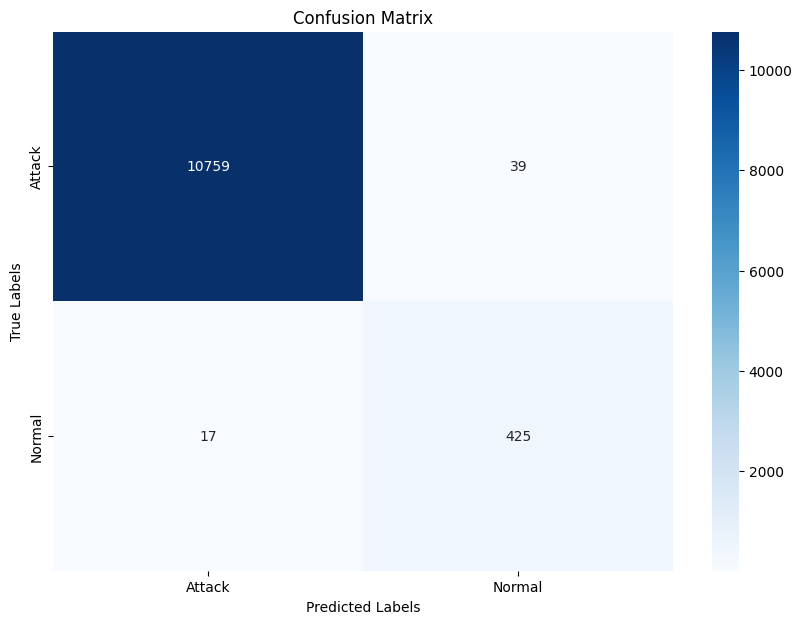

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attacks.keys(), yticklabels=attacks.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

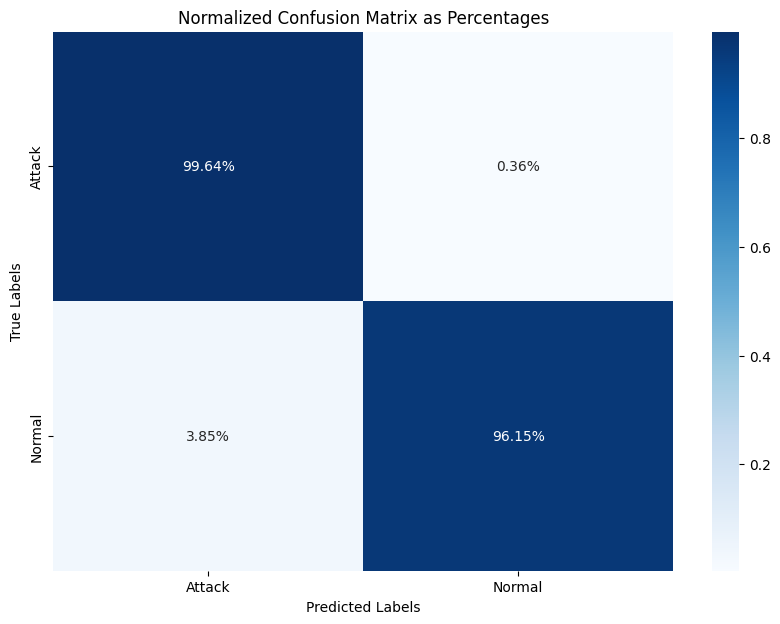

In [27]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()

In [28]:
print(optimized_model)

ExtraTreesClassifier(max_depth=17, max_features=None, min_samples_leaf=3,
                     min_samples_split=3, n_estimators=195, random_state=42)


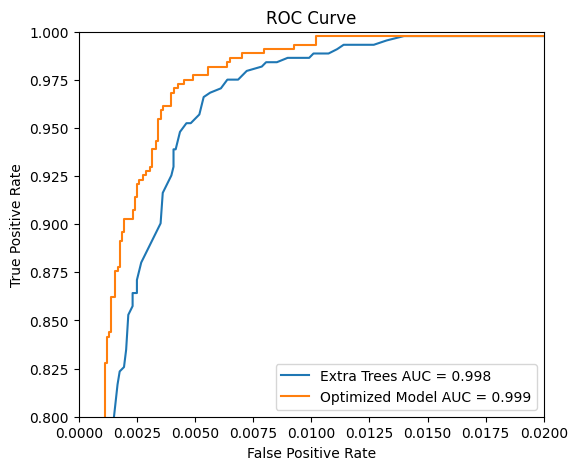

In [29]:
# Replace with the actual class labels from your dataset
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]  # for example

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Assuming you are interested in the performance with respect to class 1
y_prob_extra_trees_class1 = extra_trees.predict_proba(X_test)[:, 1]
y_prob_optimized_class1 = optimized_model.predict_proba(X_test)[:, 1]

# Now you can calculate the ROC curve for class 1
fpr_extra_trees, tpr_extra_trees, _ = roc_curve(y_test_binarized[:, 1], y_prob_extra_trees_class1)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test_binarized[:, 1], y_prob_optimized_class1)

# Calculate the AUC
auc_extra_trees = auc(fpr_extra_trees, tpr_extra_trees)
auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plotting the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_extra_trees, tpr_extra_trees, label=f'Extra Trees AUC = {auc_extra_trees:.3f}')
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Model AUC = {auc_optimized:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for reference

# Focus on the specific region of interest
plt.xlim([0, 0.02])
plt.ylim([0.8, 1.0])

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()